# Importing Libraries and Pre-Processing

In [5]:
### Importing Libraries
# basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# modeling libraries
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import make_pipeline

# Preprocessing and cross-validation
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedShuffleSplit, RepeatedKFold

# Model saving
import pickle

# Model evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib.colors import Normalize

import timeit
from datetime import timedelta

plt.rcParams["savefig.dpi"] = 300
plt.rcParams["savefig.bbox"] = 'tight'

In [6]:
### Importing and Preparing Data
# load dataset
full_train_data = pd.read_csv('train_x.csv').to_numpy()
full_train_label = pd.read_csv('train_y.csv').to_numpy().flatten()
test_data = pd.read_csv('test_x.csv').to_numpy()
test_label = pd.read_csv("test_y.csv").to_numpy().flatten()

print(f'Full train data: X = {full_train_data.shape}, y = {full_train_label.shape}')
print(f'Full test data:  X = {test_data.shape}, y = {test_label.shape}')

Full train data: X = (50000, 3072), y = (50000,)
Full test data:  X = (10000, 3072), y = (10000,)


In [7]:
# Training and Validation Set Split
train_data, val_data, train_label, val_label = train_test_split(
    full_train_data, full_train_label, test_size = 0.3, 
    stratify = full_train_label, random_state = 40)
print(f'Train data:       X = {train_data.shape}, y = {train_label.shape}')
print(f'Validation data:  X = {val_data.shape}, y = {val_label.shape}')

Train data:       X = (35000, 3072), y = (35000,)
Validation data:  X = (15000, 3072), y = (15000,)


In [8]:
# Dimensionality Reduction - PCA
pca_scaled = make_pipeline(StandardScaler(), 
                           PCA(n_components=0.8, whiten=True, random_state=0))
X_train_pca = pca_scaled.fit_transform(train_data)
X_val_pca = pca_scaled.transform(val_data)
print("PCA train data shape:      {}".format(X_train_pca.shape))
print("PCA validation data shape: {}".format(X_val_pca.shape))

PCA train data shape:      (35000, 34)
PCA validation data shape: (15000, 34)


In [5]:
# Histogram of Oriented Gradients
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure

def extract_hog(data):
    fd_array = np.empty(shape=(len(data), 3780), dtype='float')
    for i in range(len(data)):
        img = data[i]
        resized_img = resize(img, (128, 64))
        fd = hog(resized_img, orientations=9, pixels_per_cell=(8,8), 
                 cells_per_block=(2,2), transform_sqrt=True, block_norm="L1")
        fd_array[i] = fd
    return fd_array

In [6]:
X_train_hog = extract_hog(train_data)
X_val_hog = extract_hog(val_data)

In [7]:
X_full_train_hog = extract_hog(full_train_data)

In [8]:
# Dimensionality Reduction - HOG-PCA
pca_scaled2 = make_pipeline(StandardScaler(), 
                           PCA(n_components=150, whiten=False, random_state=0))
X_train_hg = pca_scaled2.fit_transform(X_train_hog)
X_val_hg = pca_scaled2.transform(X_val_hog)
print("PCA train data shape:      {}".format(X_train_hg.shape))
print("PCA validation data shape: {}".format(X_val_hg.shape))

PCA train data shape:      (42500, 150)
PCA validation data shape: (7500, 150)


# Classification

### Voting Classifier

In [10]:
# SVM model
svm_model = SVC(C=10, kernel='rbf', probability=True)

# XGBoost model
hgb_model = HistGradientBoostingClassifier(
    l2_regularization = 1, learning_rate = 0.1, max_iter = 2000, max_depth = 10)

# Random Forest Model
rf_model = RandomForestClassifier(
    n_estimators=2000, min_samples_split=5, min_samples_leaf=2, 
    max_features='sqrt', max_depth=90, criterion='gini', bootstrap=True, n_jobs = -1)

Voting Hard 1

In [8]:
# Voting Classifier - hard 
vote_model1 = VotingClassifier(
    estimators = [('svm', svm_model), ('hgb', hgb_model), ('rf', rf_model)], 
    voting = 'hard', n_jobs = -1)
params1 = {'weights': [[1, 2, 3], [2, 1, 3], None]}
vote_grid1 = GridSearchCV(estimator = vote_model1, param_grid = params1, cv=5, n_jobs=-1)
vote_grid1.fit(X_train_pca, train_label)

GridSearchCV(cv=5, error_score=nan,
             estimator=VotingClassifier(estimators=[('svm',
                                                     SVC(C=10, break_ties=False,
                                                         cache_size=200,
                                                         class_weight=None,
                                                         coef0=0.0,
                                                         decision_function_shape='ovr',
                                                         degree=3,
                                                         gamma='scale',
                                                         kernel='rbf',
                                                         max_iter=-1,
                                                         probability=True,
                                                         random_state=None,
                                                         shrinking=True,
              

In [9]:
vote_results1 = pd.DataFrame(vote_grid1.cv_results_)
print(f"best parameters:     {vote_grid1.best_params_}")                    
print(f"Train accuracy:      {vote_grid1.score(X_train_pca, train_label)}") # 0.9999764705882352
print(f"Validation accuracy: {vote_grid1.score(X_val_pca, val_label)}")     # 0.5617333333333333

best parameters:     {'weights': None}
Train accuracy:      0.9999764705882352
Validation accuracy: 0.5617333333333333


Voting Soft 2

In [7]:
# Voting Classifier - soft
vote_model2 = VotingClassifier(
    estimators = [('svm', svm_model), ('hgb', hgb_model), ('rf', rf_model)], 
    voting = 'soft', n_jobs = -1)
params2 = {'weights': [None]}
vote_grid2 = GridSearchCV(estimator = vote_model2, param_grid = params2, cv=5, n_jobs=-1)
vote_grid2.fit(X_train_pca, train_label)

GridSearchCV(cv=5, error_score=nan,
             estimator=VotingClassifier(estimators=[('svm',
                                                     SVC(C=10, break_ties=False,
                                                         cache_size=200,
                                                         class_weight=None,
                                                         coef0=0.0,
                                                         decision_function_shape='ovr',
                                                         degree=3,
                                                         gamma='scale',
                                                         kernel='rbf',
                                                         max_iter=-1,
                                                         probability=True,
                                                         random_state=None,
                                                         shrinking=True,
              

In [8]:
vote_results2 = pd.DataFrame(vote_grid2.cv_results_)
print(f"best parameters:     {vote_grid2.best_params_}")                    
print(f"Train accuracy:      {vote_grid2.score(X_train_pca, train_label)}") # 1
print(f"Validation accuracy: {vote_grid2.score(X_val_pca, val_label)}")     # 0.5785333333333333

best parameters:     {'weights': None}
Train accuracy:      1.0
Validation accuracy: 0.5785333333333333


In [6]:
# Voting Classifier - 3 
vote_model3 = VotingClassifier(
    estimators = [('svm', svm_model), ('hgb', hgb_model), ('rf', rf_model)], 
    voting = 'hard', n_jobs = -1)
params3 = {'weights': [[0.35, 0.35, 0.30]]}
vote_grid3 = GridSearchCV(estimator = vote_model3, param_grid = params3, cv=5, n_jobs=4)
vote_grid3.fit(X_train_pca, train_label)

GridSearchCV(cv=5, error_score=nan,
             estimator=VotingClassifier(estimators=[('svm',
                                                     SVC(C=10, break_ties=False,
                                                         cache_size=200,
                                                         class_weight=None,
                                                         coef0=0.0,
                                                         decision_function_shape='ovr',
                                                         degree=3,
                                                         gamma='scale',
                                                         kernel='rbf',
                                                         max_iter=-1,
                                                         probability=True,
                                                         random_state=None,
                                                         shrinking=True,
              

In [7]:
vote_results3 = pd.DataFrame(vote_grid3.cv_results_)
print(f"best parameters:     {vote_grid3.best_params_}")                    
print(f"Train accuracy:      {vote_grid3.score(X_train_pca, train_label)}") # 0.9999764705882352
print(f"Validation accuracy: {vote_grid3.score(X_val_pca, val_label)}")     # 0.5608

best parameters:     {'weights': [0.35, 0.35, 0.3]}
Train accuracy:      0.9999764705882352
Validation accuracy: 0.5608


Voting Final

In [11]:
# Building a model with all the training and validation data and testing with test data
pca_pipe = make_pipeline(StandardScaler(), 
                           PCA(n_components=0.8, whiten=True, random_state=0))
vote_mod = VotingClassifier(
    estimators = [('svm', svm_model), ('hgb', hgb_model), ('rf', rf_model)], 
    voting = 'soft', n_jobs = -1)
vote_pipe = make_pipeline(pca_pipe, vote_mod)
tic = timeit.default_timer()
vote_pipe.fit(full_train_data, full_train_label)
toc = timeit.default_timer()
print(f"time elapsed: {timedelta(seconds=toc-tic)}") # 3529.08 seconds

time elapsed: 0:24:52.858274


In [12]:
print(f"Train accuracy: {vote_pipe.score(full_train_data, full_train_label)}") # 1.0
print(f"Test accuracy:  {vote_pipe.score(test_data, test_label)}")             # 0.5845

Train accuracy: 1.0
Test accuracy:  0.5501


In [13]:
# Model prediction
pred = vote_pipe.predict(test_data)

Accuracy: 0.550
Confusion matrix:
[[634  35  44  23  25   9  27  27 126  50]
 [ 31 652  11  21  11  19  20  26  59 150]
 [ 85  28 422  85 117  59 104  52  29  19]
 [ 31  32  78 360  50 214 111  53  23  48]
 [ 43  14 116  61 462  55 117  83  30  19]
 [ 15  14  65 206  41 445  83  84  27  20]
 [ 12  25  69  62  88  48 640  23  12  21]
 [ 32  23  43  56  54  75  53 590  15  59]
 [ 78  64  17  21  14  20  13  14 695  64]
 [ 32 163   8  36  11  22  13  38  76 601]]


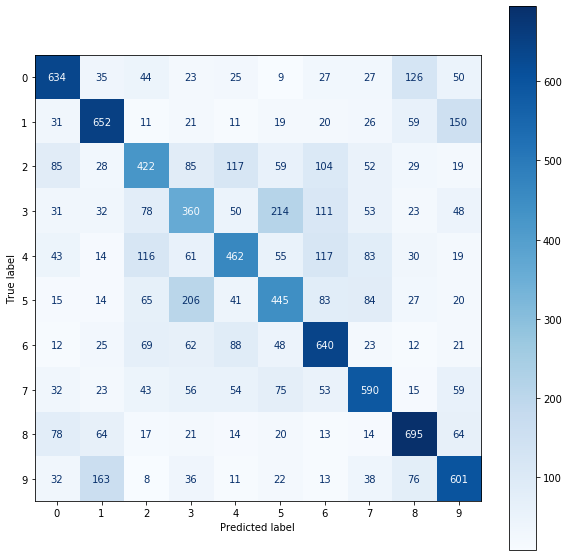

In [14]:
print(f"Accuracy: {accuracy_score(test_label, pred):.3f}")
print(f"Confusion matrix:\n{confusion_matrix(test_label, pred)}")
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay(confusion_matrix(test_label, pred), 
                       display_labels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']).plot(ax=ax, cmap=plt.cm.Blues, values_format='.0f')
plt.savefig("confusion_vote.png")

In [15]:
# Classification report
print(classification_report(test_label, pred))

              precision    recall  f1-score   support

           0       0.64      0.63      0.64      1000
           1       0.62      0.65      0.64      1000
           2       0.48      0.42      0.45      1000
           3       0.39      0.36      0.37      1000
           4       0.53      0.46      0.49      1000
           5       0.46      0.45      0.45      1000
           6       0.54      0.64      0.59      1000
           7       0.60      0.59      0.59      1000
           8       0.64      0.69      0.66      1000
           9       0.57      0.60      0.59      1000

    accuracy                           0.55     10000
   macro avg       0.55      0.55      0.55     10000
weighted avg       0.55      0.55      0.55     10000



In [16]:
# Save model file with pickle
vote_pickle = "Pickle_Vote.pkl"  

with open(vote_pickle, 'wb') as file:  
    pickle.dump(vote_pipe, file)

In [20]:
# Load model from file with pickle
vote_pickle = "Pickle_Vote.pkl" 
with open(vote_pickle, 'rb') as file:  
    pickled_vote = pickle.load(file)

pickled_vote

Pipeline(memory=None,
         steps=[('pipeline',
                 Pipeline(memory=None,
                          steps=[('standardscaler',
                                  StandardScaler(copy=True, with_mean=True,
                                                 with_std=True)),
                                 ('pca',
                                  PCA(copy=True, iterated_power='auto',
                                      n_components=100, random_state=0,
                                      svd_solver='auto', tol=0.0,
                                      whiten=True))],
                          verbose=False)),
                ('votingclassifier',
                 VotingClassifier(estimators=[('svm',
                                               SVC(C=10, break_ties=...
                                                                      max_depth=None,
                                                                      max_features='auto',
                            